# Kernel Logistic Regression

In [ ]:
from logistic import KernelLogisticRegression


logistic implementation link: https://github.com/Lia-Smith/github.io/blob/main/posts/kernal-methods-post/logistic.py

## Abstract
In this kernel logistic regression blog post, I expanded upon logistic regression by kernelizing the score and loss functions. Additionally, I explored the higher volatility that kernel function can bring to overfitting with gamma and lambda hyperparameters. 

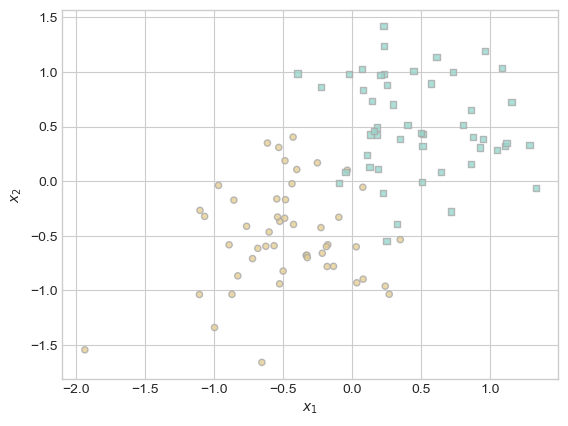

In [28]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
   
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
   
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y


def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)


In [5]:
def rbf_kernel(X_1, X_2, gamma=1.0):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)
#default kernel, encouraged to use others NOTE 


In [9]:

KR = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=1)
KR.fit(X, y, m_epochs=50000, lr=0.0001)
(1.0 * (KR.a > 0.001)).mean()


tensor(0.1900)

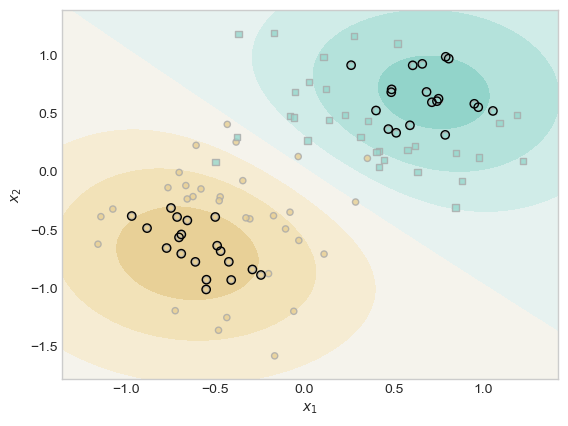

In [10]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG",
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")


## Part A: Basic Experiments

This section demonstrates basic functionality of the sparse kernel logistic regression implementation. 
I demontrate here how varying the regularization parameter `λ` and kernel width `γ` affects model sparsity and decision boundaries.


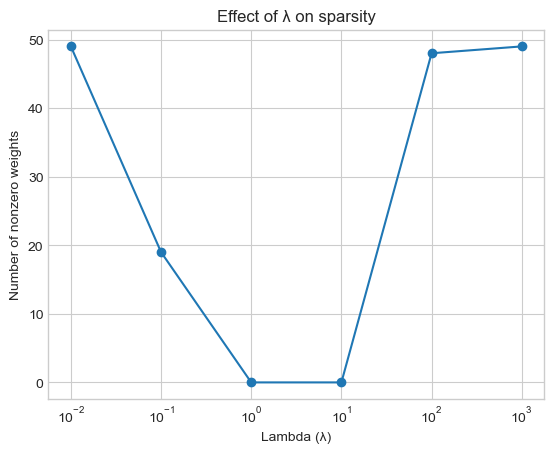

In [21]:
## lambda

lambdas = [0.01, 0.1, 1, 10, 100, 1000]
nonzero_weights = []

for lam in lambdas:
    KR = KernelLogisticRegression(rbf_kernel, lam=lam, gamma=1)
    KR.fit(X, y, m_epochs=50000, lr=0.0001)
    nonzero = (KR.a > 0.001).sum()
    nonzero_weights.append(nonzero)

plt.plot(lambdas, nonzero_weights, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (λ)')
plt.ylabel('Number of nonzero weights')
plt.title('Effect of λ on sparsity')
plt.grid(True)
plt.show()



In [22]:

import numpy as np

def plot_decision_boundary(model, X, y, h=0.02, title=None):
    """
    Plots the decision boundary learned by a KernelLogisticRegression model.

    Args:
        model: Trained KernelLogisticRegression model.
        X (torch.Tensor): Input data of shape (n, 2)
        y (torch.Tensor): Labels of shape (n,)
        h (float): Step size in the mesh.
        title (str): Optional title for the plot.
    """
    #torch to numpy
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()

    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.from_numpy(grid).float()

    # Get scores + sigmoid
    with torch.no_grad():
        scores = model.score(grid_tensor)
        probs = torch.sigmoid(scores)

    Z = probs.reshape(xx.shape)

    # Plotlolol
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=["#FFAAAA", "#AAAAFF"])
    plt.contour(xx, yy, Z, levels=[0.5], colors="k", linewidths=1)

    # Scatter original data
    plt.scatter(X_np[y_np==0][:, 0], X_np[y_np==0][:, 1], c='red', label='Class 0', edgecolors='k')
    plt.scatter(X_np[y_np==1][:, 0], X_np[y_np==1][:, 1], c='blue', label='Class 1', edgecolors='k')

    plt.legend()
    plt.title(title or "Decision Boundary")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()


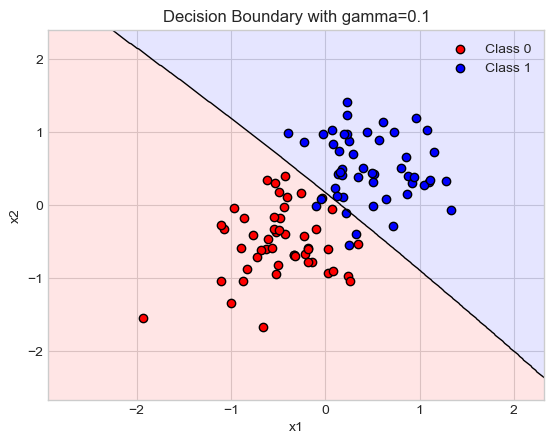

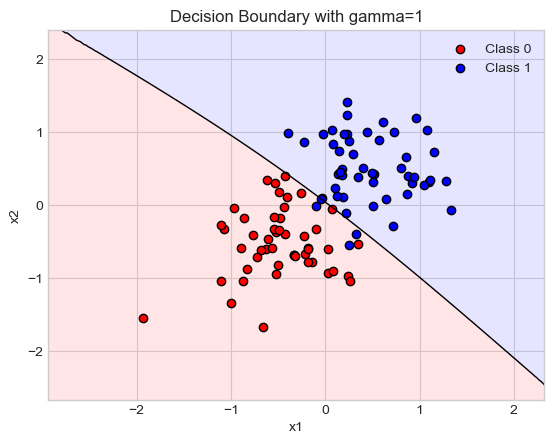

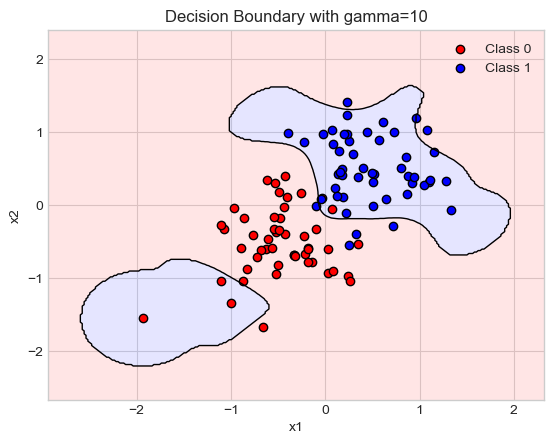

In [29]:
## gamma
gammas = [0.1, 1, 10]
for gamma in gammas:
    KR = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=gamma)
    KR.fit(X, y, m_epochs=50000, lr=0.0001)
    plot_decision_boundary(KR, X, y, title=f'Decision Boundary with gamma={gamma}')


As the value of Gamma Increases, the fluidity of the decision boundry increases.


## Part B: Demonstrating Overfitting

I created two sets of data (training and testing) and show how the wrong choice of `γ` can lead to overfitting while visualizing both the decision boundary and performance using ROC curves.


In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curves(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.score(X_train).detach().numpy()
    y_test_pred = model.score(X_test).detach().numpy()

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.2f})", color='blue')
    plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.2f})", color='red')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title("ROC Curves: Overfit Model (high λ)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

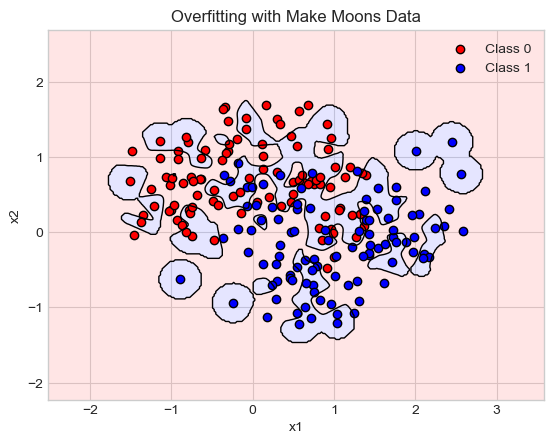

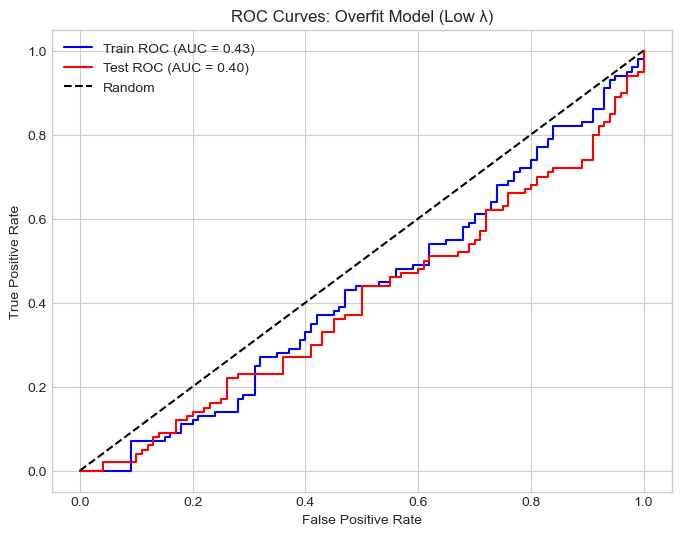

In [40]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.4)
X_test, y_test = make_moons(n_samples = 200, noise= 0.4)
#np to tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

#model
KR = KernelLogisticRegression(rbf_kernel, lam=0.5, gamma=100)
KR.fit(X, y, m_epochs=50000, lr=0.0001)
plot_decision_boundary(KR, X, y, title = "Overfitting with Make Moons Data")

plot_roc_curves(KR, X, y, X_test, y_test)
